# Binary-Class Model for KDD Cup 1998 Using Python and Scikit-Learn Take 1
### David Lowe
### April 4, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Acoustic Extinguisher Fire dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: This is the data set used for The Second International Knowledge Discovery and Data Mining Tools Competition, held in conjunction with KDD-98, The Fourth International Conference on Knowledge Discovery and Data Mining. The modeling task is a binary classification problem where the goal is to estimate the likelihood of donation from a direct mailing campaign.

In this Take1 iteration, we will build and test models using the minimal set of basic features. The final model will serve as the baseline result as we employ more features in future iterations.

ANALYSIS: In this iteration, the average performance of the machine learning algorithms achieved a ROC/AUC benchmark of 70.99% using the training dataset. Furthermore, we selected Random Forest as the final model as it processed the training dataset with a final ROC/AUC score of 77.23%. When we processed the test dataset with the last model, the model achieved a ROC/AUC score of 50.42%.

CONCLUSION: In this iteration, the Random Forest model appeared to be suitable for modeling this dataset. However, we should explore the possibilities of using more features from the dataset to model this problem.

Dataset Used: KDD Cup 1998 Dataset

Dataset ML Model: Binary classification with numerical and categorical features

Dataset Reference: https://kdd.org/kdd-cup/view/kdd-cup-1998/Data

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.15
VAL_SET_RATIO = 0.15

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'roc_auc'

# Define the directory locations and file names
TRAIN_DATASET = 'cup98LRN.txt'
TEST_DATASET = 'cup98VAL.txt'
TARGET_DATASET = 'valtargt.txt'

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/ucirvine-kdd-cup-1998/cup98LRN.txt

In [8]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, sep=',', index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


   ODATEDW OSOURCE  TCODE STATE    ZIP MAILCODE PVASTATE   DOB NOEXCH  \
0     8901     GRI      0    IL  61081                    3712      0   
1     9401     BOA      1    CA  91326                    5202      0   
2     9001     AMH      1    NC  27017                       0      0   
3     8701     BRY      0    CA  95953                    2801      0   
4     8601              0    FL  33176                    2001      0   

  RECINHSE  ... TARGET_D HPHONE_D RFA_2R RFA_2F RFA_2A MDMAUD_R  MDMAUD_F  \
0           ...      0.0        0      L      4      E        X         X   
1           ...      0.0        0      L      2      G        X         X   
2           ...      0.0        1      L      4      E        X         X   
3           ...      0.0        1      L      4      E        X         X   
4        X  ...      0.0        1      L      2      F        X         X   

  MDMAUD_A CLUSTER2 GEOCODE2  
0        X     39.0        C  
1        X      1.0        A  
2    

In [9]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 481 columns):
 #    Column    Dtype  
---   ------    -----  
 0    ODATEDW   int64  
 1    OSOURCE   object 
 2    TCODE     int64  
 3    STATE     object 
 4    ZIP       object 
 5    MAILCODE  object 
 6    PVASTATE  object 
 7    DOB       int64  
 8    NOEXCH    object 
 9    RECINHSE  object 
 10   RECP3     object 
 11   RECPGVG   object 
 12   RECSWEEP  object 
 13   MDMAUD    object 
 14   DOMAIN    object 
 15   CLUSTER   object 
 16   AGE       float64
 17   AGEFLAG   object 
 18   HOMEOWNR  object 
 19   CHILD03   object 
 20   CHILD07   object 
 21   CHILD12   object 
 22   CHILD18   object 
 23   NUMCHLD   float64
 24   INCOME    float64
 25   GENDER    object 
 26   WEALTH1   float64
 27   HIT       int64  
 28   MBCRAFT   float64
 29   MBGARDEN  float64
 30   MBBOOKS   float64
 31   MBCOLECT  float64
 32   MAGFAML   float64
 33   MAGFEM    float64
 34   MAGMALE   float64
 3

In [10]:
print(df_dataset_import.describe())

            ODATEDW         TCODE           DOB           AGE       NUMCHLD  \
count  95412.000000  95412.000000  95412.000000  71747.000000  12386.000000   
mean    9141.363256     54.223117   2723.602933     61.611649      1.527773   
std      343.454752    953.844476   2132.241295     16.664199      0.806861   
min     8306.000000      0.000000      0.000000      1.000000      1.000000   
25%     8801.000000      0.000000    201.000000     48.000000      1.000000   
50%     9201.000000      1.000000   2610.000000     62.000000      1.000000   
75%     9501.000000      2.000000   4601.000000     75.000000      2.000000   
max     9701.000000  72002.000000   9710.000000     98.000000      7.000000   

             INCOME       WEALTH1           HIT       MBCRAFT      MBGARDEN  \
count  74126.000000  50680.000000  95412.000000  42558.000000  42558.000000   
mean       3.886248      5.345699      3.321438      0.152075      0.059166   
std        1.854960      2.742490      9.306899    

In [11]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

ODATEDW       0
OSOURCE       0
TCODE         0
STATE         0
ZIP           0
           ... 
MDMAUD_R      0
MDMAUD_F      0
MDMAUD_A      0
CLUSTER2    132
GEOCODE2    132
Length: 481, dtype: int64
Total number of NaN in the dataframe:  5158796


In [12]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('TARGET_B').size())

TARGET_B
0    90569
1     4843
dtype: int64


### 1.d) Data Cleaning

In [13]:
# Setting up various helper functions for data cleaning

# Drop all columns between (and including) two column names
def drop_columns(df, begin_string='', end_string=''):
    col_names = list(df.columns)
    begin_index = col_names.index(begin_string)
    end_index = col_names.index(end_string) + 1
    drop_cols = col_names[begin_index:end_index]
    print('Dropping colunms:', drop_cols)
    df.drop(columns=drop_cols, inplace=True)

# Convert categorical features with blanks to value U for Unknown
def reclass_Blank_U(target_col):
    if target_col == ' ': return 'U'
    else: return target_col

# Convert numeric features with blanks to value 99
def reclass_Blank_99(target_col):
    if target_col == ' ': return '99'
    else: return target_col

# Convert features with two levels (X and blank) into integers of 1 or 0
def reclass_X_blank(target_col):
    if target_col == 'X': return 1
    else: return 0

def fill_X_Blank_cols(df, begin_string='', end_string=''):
    col_names = list(df.columns)
    begin_index = col_names.index(begin_string)
    end_index = col_names.index(end_string) + 1
    X_blank_cols = col_names[begin_index:end_index]
    print('Filling X/Blank colunms with values:', X_blank_cols)
    for col in X_blank_cols:
        df[col] = df[col].apply(reclass_X_blank)

# Convert features with two levels (Y and N) into integers of 1 or 0
def reclass_Y_blank(target_col):
    if target_col == 'Y': return 1
    else: return 0

def fill_Y_Blank_cols(df, begin_string='', end_string=''):
    col_names = list(df.columns)
    begin_index = col_names.index(begin_string)
    end_index = col_names.index(end_string) + 1
    Y_blank_cols = col_names[begin_index:end_index]
    print('Filling Y/N colunms with values:', Y_blank_cols)
    for col in Y_blank_cols:
        df[col] = df[col].apply(reclass_Y_blank)

# Convert the Domain feature into two separate Urbanicity and SES features
def convert_domain_urb(target_col):
    if len(target_col) == 2:
        return target_col[0]
    else:
        return 'X'

def convert_domain_ses(target_col):
    if len(target_col) == 2:
        return target_col[1]
    else:
        return 'X'

def fill_integer_cols(df, begin_string='', end_string=''):
    col_names = list(df.columns)
    begin_index = col_names.index(begin_string)
    end_index = col_names.index(end_string) + 1
    integer_cols = col_names[begin_index:end_index]
    print('Filling integer colunms with zeros:', integer_cols)
    for col in integer_cols:
        df[col].fillna(value=0, inplace=True)
        df[col] = df[col].astype('int')

In [14]:
# Helper function for cleaning the training and test dataset and ensure consistency
def clean_dataset(df):
    # Clean up the basic donor features
    df['PVASTATE'] = df['PVASTATE'].apply(reclass_Blank_U)
    fill_X_Blank_cols(df, 'RECINHSE', 'RECSWEEP')
    df['DOMAIN_URB'] = df['DOMAIN'].apply(convert_domain_urb)
    df['DOMAIN_SES'] = df['DOMAIN'].apply(convert_domain_ses)
    df['AGE'].fillna(value=df['AGE'].median(), inplace=True)
    df['AGE'] = df['AGE'].astype('int')
    df['HOMEOWNR'] = df['HOMEOWNR'].apply(reclass_Blank_U)
    df['CHILD03'] = df['CHILD03'].apply(reclass_Blank_U)
    df['CHILD07'] = df['CHILD07'].apply(reclass_Blank_U)
    df['CHILD12'] = df['CHILD12'].apply(reclass_Blank_U)
    df['CHILD18'] = df['CHILD18'].apply(reclass_Blank_U)
    df['NUMCHLD'].fillna(value=0, inplace=True)
    df['NUMCHLD'] = df['NUMCHLD'].astype('int')
    df['INCOME'].fillna(value=df['INCOME'].median(), inplace=True)
    df['INCOME'] = df['INCOME'].astype('int')
    df['GENDER'] = df['GENDER'].apply(reclass_Blank_U)
    df['WEALTH1'].fillna(value=df['WEALTH1'].median(), inplace=True)
    df['WEALTH1'] = df['WEALTH1'].astype('int')
    df.drop(columns=['ODATEDW','OSOURCE','TCODE','STATE','ZIP',
                     'MAILCODE','DOB','NOEXCH','MDMAUD','DOMAIN',
                     'CLUSTER','AGEFLAG'], inplace=True)

    # CLean up the Mail Order Offers features
    drop_columns(df, 'MBCRAFT', 'PUBOPP')

    # Clean up the 3rd Party Overlay features
    drop_columns(df, 'DATASRCE', 'GEOCODE')

    # Clean up the 3rd Party Donor Interest features
    drop_columns(df, 'COLLECT1', 'LIFESRC')

    # Clean up the PEP Star RFA Status feature
    df['PEPSTRFL'] = df['PEPSTRFL'].apply(reclass_X_blank)

    # Clean up the 1990 US Census Neighborhood Data features
    drop_columns(df, 'POP901', 'AC2')

    # Clean up the Promotion History and Summary features
    drop_columns(df, 'ADATE_2', 'RFA_24')
    drop_columns(df, 'CARDPROM', 'NUMPRM12')

    # Clean up the Giving History and Summary features
    drop_columns(df, 'RDATE_3', 'RAMNT_24')
    drop_columns(df, 'RAMNTALL', 'AVGGIFT')

    # Drop the Unique Control Numbers and other miscellaneous variables
    df.drop(columns=['CONTROLN','RFA_2R','CLUSTER2','GEOCODE2'], inplace=True)

In [15]:
# Clean up the training dataset
clean_dataset(df_dataset_import)

# Standardize the class column to the name of targetVar if required
df_dataset_import.drop(columns=['TARGET_D'], inplace=True)
df_dataset_import = df_dataset_import.rename(columns={'TARGET_B': 'target'})

Filling X/Blank colunms with values: ['RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP']
Dropping colunms: ['MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP']
Dropping colunms: ['DATASRCE', 'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'SOLP3', 'SOLIH', 'MAJOR', 'WEALTH2', 'GEOCODE']
Dropping colunms: ['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'LIFESRC']
Dropping colunms: ['POP901', 'POP902', 'POP903', 'POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5', 'ETH1', 'ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9', 'ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16', 'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3', 'AGE

In [16]:
# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  PVASTATE  RECINHSE  RECP3  RECPGVG  RECSWEEP  AGE HOMEOWNR CHILD03 CHILD07  \
0        U         0      0        0         0   60        U       U       U   
1        U         0      0        0         0   46        H       U       U   
2        U         0      0        0         0   62        U       U       U   
3        U         0      0        0         0   70        U       U       U   
4        U         1      1        0         0   78        H       U       U   

  CHILD12  ... PEPSTRFL  target  HPHONE_D RFA_2F  RFA_2A  MDMAUD_R  MDMAUD_F  \
0       U  ...        1       0         0      4       E         X         X   
1       U  ...        0       0         0      2       G         X         X   
2       U  ...        1       0         1      4       E         X         X   
3       U  ...        1       0         1      4       E         X         X   
4       U  ...        0       0         1      2       F         X         X   

   MDMAUD_A  DOMAIN_URB  DOMAIN_SES  


In [17]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PVASTATE    95412 non-null  object
 1   RECINHSE    95412 non-null  int64 
 2   RECP3       95412 non-null  int64 
 3   RECPGVG     95412 non-null  int64 
 4   RECSWEEP    95412 non-null  int64 
 5   AGE         95412 non-null  int64 
 6   HOMEOWNR    95412 non-null  object
 7   CHILD03     95412 non-null  object
 8   CHILD07     95412 non-null  object
 9   CHILD12     95412 non-null  object
 10  CHILD18     95412 non-null  object
 11  NUMCHLD     95412 non-null  int64 
 12  INCOME      95412 non-null  int64 
 13  GENDER      95412 non-null  object
 14  WEALTH1     95412 non-null  int64 
 15  HIT         95412 non-null  int64 
 16  PEPSTRFL    95412 non-null  int64 
 17  target      95412 non-null  int64 
 18  HPHONE_D    95412 non-null  int64 
 19  RFA_2F      95412 non-null  int64 
 20  RFA_2A

In [18]:
print(df_dataset_import.describe())

           RECINHSE         RECP3       RECPGVG      RECSWEEP           AGE  \
count  95412.000000  95412.000000  95412.000000  95412.000000  95412.000000   
mean       0.070253      0.021140      0.001195      0.016948     61.707972   
std        0.255575      0.143851      0.034546      0.129076     14.451513   
min        0.000000      0.000000      0.000000      0.000000      1.000000   
25%        0.000000      0.000000      0.000000      0.000000     52.000000   
50%        0.000000      0.000000      0.000000      0.000000     62.000000   
75%        0.000000      0.000000      0.000000      0.000000     71.000000   
max        1.000000      1.000000      1.000000      1.000000     98.000000   

            NUMCHLD        INCOME       WEALTH1           HIT      PEPSTRFL  \
count  95412.000000  95412.000000  95412.000000  95412.000000  95412.000000   
mean       0.198329      3.911625      5.652455      3.321438      0.474458   
std        0.590066      1.635685      2.025250    

In [19]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

PVASTATE      0
RECINHSE      0
RECP3         0
RECPGVG       0
RECSWEEP      0
AGE           0
HOMEOWNR      0
CHILD03       0
CHILD07       0
CHILD12       0
CHILD18       0
NUMCHLD       0
INCOME        0
GENDER        0
WEALTH1       0
HIT           0
PEPSTRFL      0
target        0
HPHONE_D      0
RFA_2F        0
RFA_2A        0
MDMAUD_R      0
MDMAUD_F      0
MDMAUD_A      0
DOMAIN_URB    0
DOMAIN_SES    0
dtype: int64
Total number of NaN in the dataframe:  0


In [20]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    90569
1     4843
dtype: int64


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

# print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))
print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (95412, 26) df_features_train.shape: (95412, 25) df_target_train.shape: (95412,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

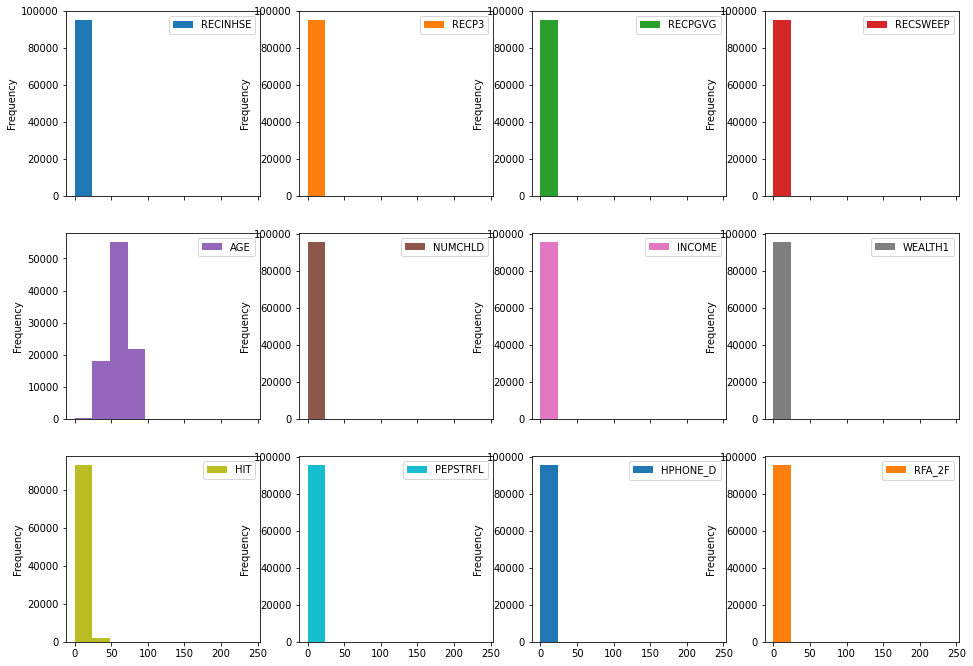

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

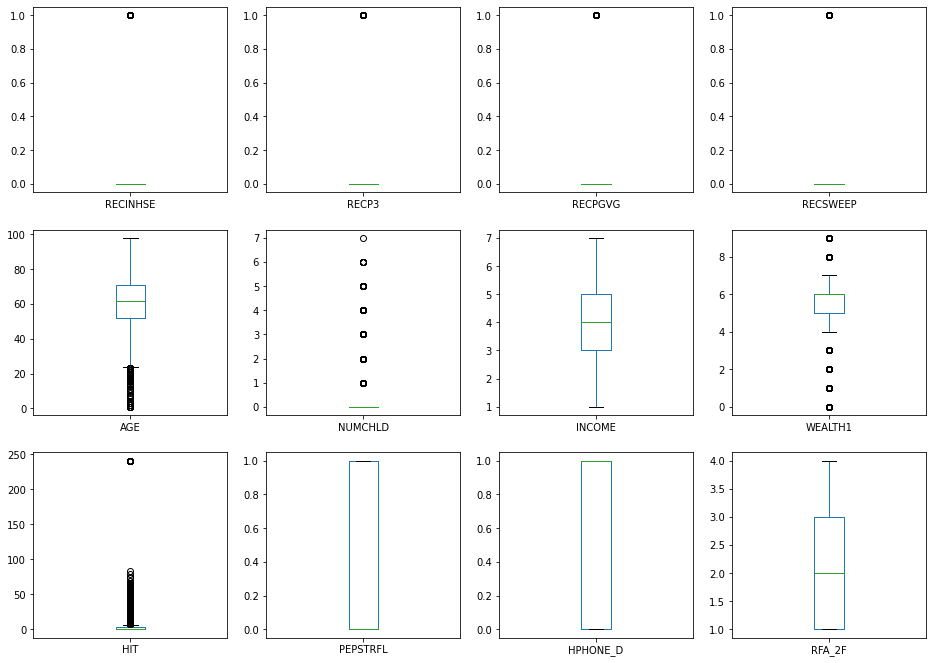

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [27]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 0
Number of categorical columns: 13
Total number of columns in the feature dataframe: 25


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (95412, 25) to array_features_train.shape: (95412, 68)


### 3.b) Training Data Balancing

In [32]:
# Perform SMOTE transformation on the training data (Block #1 of 2)
X_train_imbal = array_features_train
y_train_imbal = df_target_train.ravel()
print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

X_train_imbal.shape: (95412, 68) y_train_imbal.shape: (95412,)


In [33]:
# Perform SMOTE transformation on the training data (Block #2 of 2)
print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
over_sample = SMOTE(sampling_strategy=0.1, random_state=RNG_SEED)
under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=RNG_SEED)
steps = [('o', over_sample), ('u', under_sample)]
sample_pipeline = Pipeline(steps=steps)
array_features_train, y_train_balanced = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train_balanced==1).sum(), (y_train_balanced==0).sum()))

Original class distribution - 1: 4843 | 0: 90569
Resampled class distribution - 1: 9056 | 0: 9056


### 3.c) Feature Selection

In [34]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [35]:
# Finalize the training dataset for the modeling activities
# array_target_train = df_target_train.ravel()
array_target_train = y_train_balanced.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (18112, 68) array_target_train.shape: (18112,)


In [36]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [38]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [39]:
train_models.append(('LGR', LogisticRegression(solver='liblinear', random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [40]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LGR: 0.618843 (0.009772)
LogisticRegression(n_jobs=1, random_state=888, solver='liblinear')
Model training time: 0:00:01.308519 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CART: 0.659774 (0.008161)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:00.677222 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN: 0.694022 (0.003986)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:00:07.581777 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.757995 (0.004552)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:04.252326 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.771061 (0.007237)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:10.477022 

EXT: 0.758270 (0.006946)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:14.708424 

Average metrics (roc_auc) from all models: 0.709994140559286
Total training time for all models: 0:00:39.031530


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.7s finished


### 4.b) Spot-checking baseline algorithms

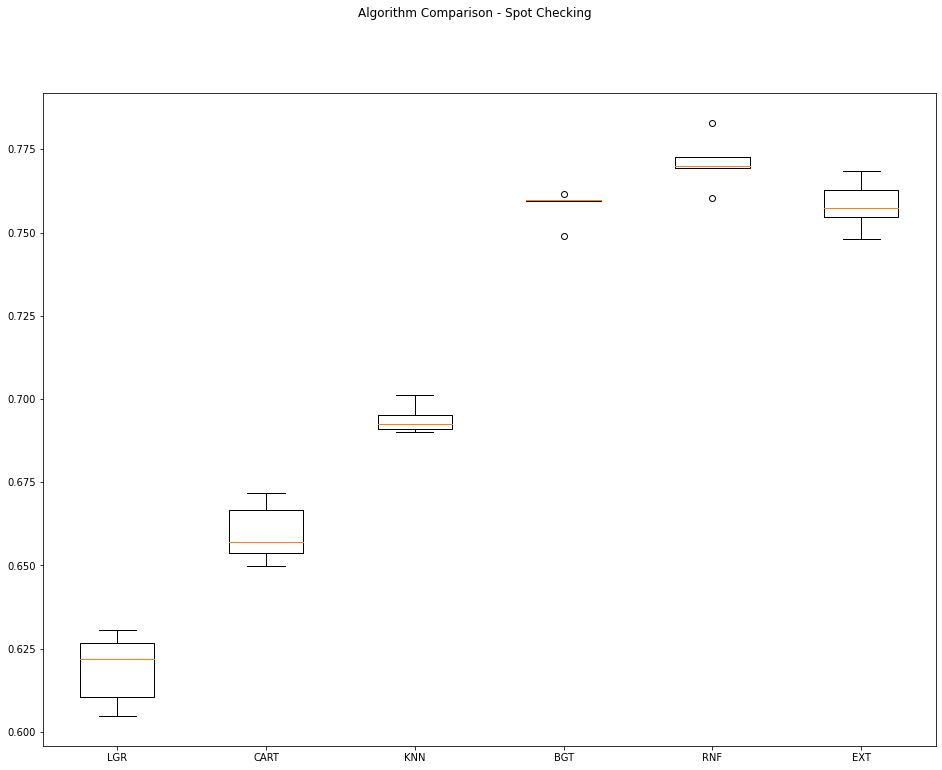

In [41]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [42]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Algorithm Tuning

In [43]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [44]:
# Tuning algorithm #1
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('BGT')
paramGrid1 = dict(n_estimators=np.array([10, 30, 50]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.767190 using {'n_estimators': 50}
0.757995 (0.004552) with: {'n_estimators': 10}
0.765336 (0.005767) with: {'n_estimators': 30}
0.767190 (0.006334) with: {'n_estimators': 50}
Model training time: 0:00:43.138667


In [45]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 50


In [46]:
# Tuning algorithm #2
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.772386 using {'n_estimators': 300}
0.771061 (0.007237) with: {'n_estimators': 100}
0.772386 (0.007221) with: {'n_estimators': 300}
0.772378 (0.007121) with: {'n_estimators': 500}
Model training time: 0:01:38.846574


In [47]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 300


### 4.d) Compare Algorithms After Tuning

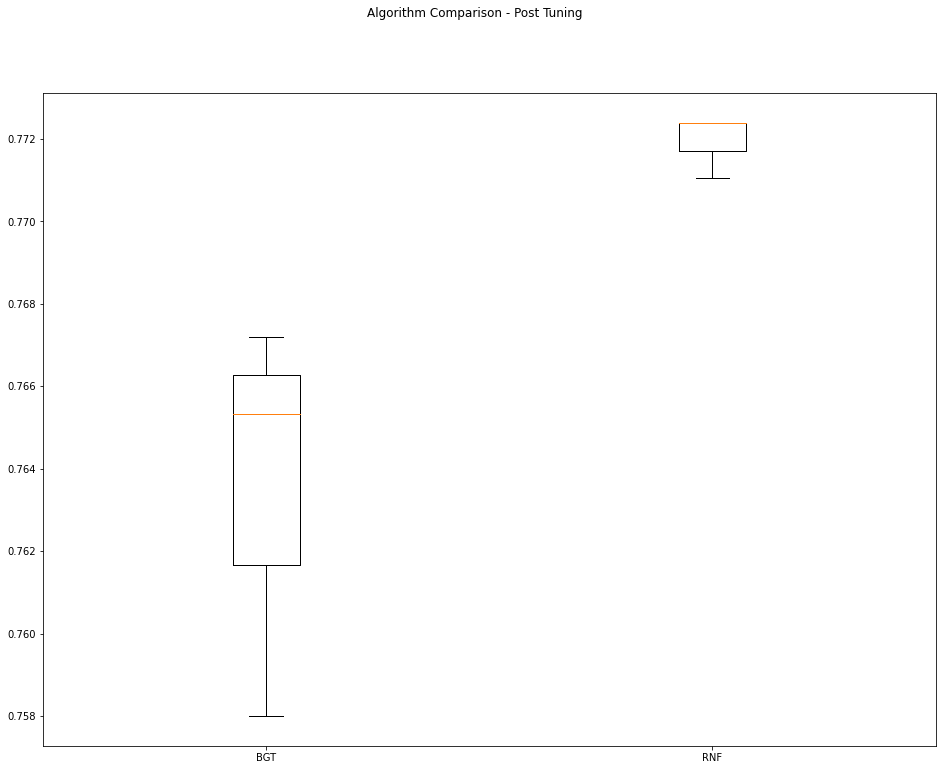

In [48]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [49]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [50]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [51]:
final_model = RandomForestClassifier(n_estimators=best_paramValue2, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

RandomForestClassifier(n_estimators=300, n_jobs=1, random_state=888)


### 5.b) Load Test Dataset and Make Predictions

In [52]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/ucirvine-kdd-cup-1998/cup98VAL.txt

In [53]:
df_features_test = pd.read_csv(TEST_DATASET, sep=',', index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


   ODATEDW OSOURCE  TCODE STATE     ZIP MAILCODE PVASTATE   DOB NOEXCH  \
0     9301     PV3      0    WI   53558                    1702      0   
1     9501     CNT      0    TX   78501                    1501      0   
2     9101     L01      1    CA   92392                    3001      0   
3     9401     HAM      0    TX  77625-                    4909      0   
4     9201     NAS      2    TX   76051                    5406      0   

  RECINHSE  ... CONTROLN HPHONE_D RFA_2R RFA_2F RFA_2A MDMAUD_R  MDMAUD_F  \
0        X  ...   188946        1      L      1      G        X         X   
1           ...   126296        1      L      1      F        X         X   
2           ...   155244        1      L      1      G        X         X   
3           ...   123985        0      L      1      F        X         X   
4           ...   119118        1      L      3      E        X         X   

  MDMAUD_A CLUSTER2 GEOCODE2  
0        X     15.0        B  
1        X     13.0        B  

In [54]:
df_features_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96367 entries, 0 to 96366
Data columns (total 479 columns):
 #    Column    Dtype  
---   ------    -----  
 0    ODATEDW   int64  
 1    OSOURCE   object 
 2    TCODE     int64  
 3    STATE     object 
 4    ZIP       object 
 5    MAILCODE  object 
 6    PVASTATE  object 
 7    DOB       int64  
 8    NOEXCH    object 
 9    RECINHSE  object 
 10   RECP3     object 
 11   RECPGVG   object 
 12   RECSWEEP  object 
 13   MDMAUD    object 
 14   DOMAIN    object 
 15   CLUSTER   object 
 16   AGE       float64
 17   AGEFLAG   object 
 18   HOMEOWNR  object 
 19   CHILD03   object 
 20   CHILD07   object 
 21   CHILD12   object 
 22   CHILD18   object 
 23   NUMCHLD   float64
 24   INCOME    float64
 25   GENDER    object 
 26   WEALTH1   float64
 27   HIT       int64  
 28   MBCRAFT   float64
 29   MBGARDEN  float64
 30   MBBOOKS   float64
 31   MBCOLECT  float64
 32   MAGFAML   float64
 33   MAGFEM    float64
 34   MAGMALE   float64
 3

In [55]:
print(df_features_test.isnull().sum())
print('Total number of NaN in the dataframe: ', df_features_test.isnull().sum().sum())

ODATEDW       0
OSOURCE       0
TCODE         0
STATE         0
ZIP           0
           ... 
MDMAUD_R      0
MDMAUD_F      0
MDMAUD_A      0
CLUSTER2    128
GEOCODE2    128
Length: 479, dtype: int64
Total number of NaN in the dataframe:  5212774


In [56]:
# Clean up the training dataset
clean_dataset(df_features_test)

Filling X/Blank colunms with values: ['RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP']
Dropping colunms: ['MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP']
Dropping colunms: ['DATASRCE', 'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'SOLP3', 'SOLIH', 'MAJOR', 'WEALTH2', 'GEOCODE']
Dropping colunms: ['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'LIFESRC']
Dropping colunms: ['POP901', 'POP902', 'POP903', 'POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5', 'ETH1', 'ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9', 'ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16', 'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3', 'AGE

In [57]:
# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  PVASTATE  RECINHSE  RECP3  RECPGVG  RECSWEEP  AGE HOMEOWNR CHILD03 CHILD07  \
0        U         1      0        0         0   81        U       U       U   
1        U         0      0        0         0   83        U       U       U   
2        U         0      0        0         0   68        U       U       U   
3        U         0      0        0         0   48        U       U       U   
4        U         0      0        0         0   44        H       U       U   

  CHILD12  ... HIT  PEPSTRFL  HPHONE_D RFA_2F  RFA_2A  MDMAUD_R  MDMAUD_F  \
0       U  ...   2         0         1      1       G         X         X   
1       U  ...   0         0         1      1       F         X         X   
2       U  ...   0         0         1      1       G         X         X   
3       U  ...   0         0         0      1       F         X         X   
4       M  ...  15         1         1      3       E         X         X   

   MDMAUD_A  DOMAIN_URB DOMAIN_SES  
0         X        

In [58]:
df_features_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96367 entries, 0 to 96366
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PVASTATE    96367 non-null  object
 1   RECINHSE    96367 non-null  int64 
 2   RECP3       96367 non-null  int64 
 3   RECPGVG     96367 non-null  int64 
 4   RECSWEEP    96367 non-null  int64 
 5   AGE         96367 non-null  int64 
 6   HOMEOWNR    96367 non-null  object
 7   CHILD03     96367 non-null  object
 8   CHILD07     96367 non-null  object
 9   CHILD12     96367 non-null  object
 10  CHILD18     96367 non-null  object
 11  NUMCHLD     96367 non-null  int64 
 12  INCOME      96367 non-null  int64 
 13  GENDER      96367 non-null  object
 14  WEALTH1     96367 non-null  int64 
 15  HIT         96367 non-null  int64 
 16  PEPSTRFL    96367 non-null  int64 
 17  HPHONE_D    96367 non-null  int64 
 18  RFA_2F      96367 non-null  int64 
 19  RFA_2A      96367 non-null  object
 20  MDMAUD

In [59]:
print(df_features_test.isnull().sum())
print('Total number of NaN in the dataframe: ', df_features_test.isnull().sum().sum())

PVASTATE      0
RECINHSE      0
RECP3         0
RECPGVG       0
RECSWEEP      0
AGE           0
HOMEOWNR      0
CHILD03       0
CHILD07       0
CHILD12       0
CHILD18       0
NUMCHLD       0
INCOME        0
GENDER        0
WEALTH1       0
HIT           0
PEPSTRFL      0
HPHONE_D      0
RFA_2F        0
RFA_2A        0
MDMAUD_R      0
MDMAUD_F      0
MDMAUD_A      0
DOMAIN_URB    0
DOMAIN_SES    0
dtype: int64
Total number of NaN in the dataframe:  0


In [60]:
if not os.path.exists(TARGET_DATASET):
    !wget https://dainesanalytics.com/datasets/ucirvine-kdd-cup-1998/valtargt.txt

In [61]:
df_target_test = pd.read_csv(TARGET_DATASET, sep=',', index_col=False)

# Take a peek at the dataframe after import
print(df_target_test.head())

   CONTROLN  TARGET_B  TARGET_D
0         3         0       0.0
1         6         0       0.0
2         9         0       0.0
3        11         0       0.0
4        16         0       0.0


In [62]:
# Drop unimportant features from various info sections
df_target_test.drop(columns=['CONTROLN','TARGET_D'], inplace=True)

# Take a peek at the dataframe after import
print(df_target_test.head())

   TARGET_B
0         0
1         0
2         0
3         0
4         0


In [63]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = df_target_test['TARGET_B'].ravel()
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (96367, 68) array_target_test.shape: (96367,)


In [64]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[0 0 0 ... 0 0 0]


In [65]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.7794265671858623
ROC/AUC Score: 0.5042109496394106
[[74146 17348]
 [ 3908   965]]
              precision    recall  f1-score   support

           0       0.95      0.81      0.87     91494
           1       0.05      0.20      0.08      4873

    accuracy                           0.78     96367
   macro avg       0.50      0.50      0.48     96367
weighted avg       0.90      0.78      0.83     96367



In [66]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [67]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:03:42.279969
